In [1]:
import numpy as np
import cvxpy as cp

import scipy

from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

import torch, numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt

import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
class SyntheticSignals():
    def __init__(self, A, n, m, p = 0.1, s_sigma = 1, SNR = None, size = 1000, batch_size = 512):
        
        # Model complexity
        self.n = n                          # Number of samples in the original signal
        self.m = m                          # Number of samples through the linear transformation

        # Sensing matrix
        if A is None:                           
            self.A = self.A_initialization()          
        else:
            self.A = A

        # Sparsity and noise
        self.p = p                          # Sparsity of the signal in terms of percentage of components being non zero

        self.s_sigma = s_sigma              # Scale of the original sparse signals             
        self.SNR = SNR                      # Signal-to-noise ratio 

        # Size and batchsize
        self.batch_size = batch_size
        self.size = size                    # Size of the dataset

        # Preallocation
        self.x = torch.zeros(self.size,self.n)
        self.y = torch.zeros(self.size,self.m)
        
        # Generating the dataset
        self.set_data()

    def A_initialization(self):

        A = torch.normal(0, torch.sqrt(torch.tensor(1/self.n)), size = (self.m, self.n))
        A /= torch.linalg.norm(A, dim = 0)
        return A
    
    def set_tuple(self, i):

        # Generating random sparsity in the canonic basis of the original signal
        idxs = np.random.choice(self.n, int(self.p * self.n), replace=False)
        peaks = np.random.normal(scale=self.s_sigma, size = int(self.p * self.n))

        # Generating the original signal and its corrupted observations
        self.x[i, idxs] = torch.from_numpy(peaks).to(self.x)
        self.y[i,:] = self.A @ self.x[i,:] 
        
        if self.SNR is not None:
            var = torch.mean(self.y[i,:]**2) / self.SNR
            self.y[i,:] += torch.normal(mean = 0, std=torch.sqrt(torch.tensor(var)), size=(self.m,))

    def set_data(self):
        for i in range(self.size):
            self.set_tuple(i)
    
    
    def set_loader(self):
        return Data.DataLoader(dataset = Data.TensorDataset(self.y, self.x),
                               batch_size = self.batch_size,
                               shuffle = True)

In [11]:
class NCS_LAYER(nn.Module):
    def __init__(self, A, mode, config, lambd = 0.1):
        super().__init__()

        assert mode in ['EXP', 'PNEG', 'SCAD']
        assert config in [1,2,3]

        self.A = A
        self.L = torch.max(torch.real(torch.linalg.eigvals(A.t() @ A)))
        self.mode = mode
        self.config = config

        # Initialization of the learnable parameter
        self.theta = nn.Parameter(torch.ones(1), requires_grad=True)  
        self.mu = nn.Parameter(torch.ones(1) / self.L, requires_grad=True)  
        self.lambd = nn.Parameter(torch.ones(1) * lambd, requires_grad=True)  
        self.xi = nn.Parameter(torch.ones(1) * lambd / self.L, requires_grad=True)  

        # Mode setting for the layer
        if mode == 'EXP':
            self.ddx = self.ddxEXP
            self.eta = self.etaEXP

        if mode == 'PNEG':
            self.p = - 0.5
            self.ddx = self.ddxNEG
            self.eta = self.etaNEG

        if mode == 'SCAD':
            self.a = 2
            self.ddx = self.ddxSCAD
            self.eta = self.etaSCAD

    #_________________________________________________________________
    #______________ METHODS FOR ENABLING DIFFERENT LAYERS_____________
    #_________________________________________________________________
    
    # Derivatives of the nonconvex components
    def ddxEXP(self, x):
        return torch.sign(x) * self.theta * (1 - torch.exp(-self.theta * torch.abs(x)))

    def ddxPOS(self, x):
        return (1 / self.theta) * torch.sign(x) * (self.eps**(1 / self.theta - 1) - (torch.abs(x) + self.eps)**(1 / self.theta - 1))

    def ddxNEG(self, x):
        return -torch.sign(x) * self.p * self.theta * (1 - (1 + self.theta * torch.abs(x))**(self.p - 1))

    def ddxSCAD(self, x):
        abs_x = torch.abs(x)
        
        mask1 = (abs_x <= 1)
        mask2 = (1 / self.theta < abs_x) & (abs_x <= self.a / self.theta)
        mask3 = (abs_x > self.a / self.theta)
        
        # Compute the value for each condition
        val1 = torch.zeros_like(x)
        val2 = torch.sign(x) * (2 * self.theta * (self.theta * abs_x - 1)) / (self.a**2 - 1)
        val3 = torch.sign(x) * (2 * self.theta / (self.a + 1))
        
        # Apply the masks to compute the final result
        result = torch.where(mask1, val1, torch.where(mask2, val2, val3))
        
        return result

    def ddxLOG(self, x):
        return torch.sign(x) * (self.theta**2 * torch.abs(x)) / (torch.log(1 + self.theta) * (1 + self.theta * torch.abs(x)))

    # Parametrization for the surrogates
    def etaEXP(self):
        return self.theta

    def etaPOS(self):
        return 1 / self.theta * self.eps ** (1 / self.theta - 1)

    def etaNEG(self):
        return - self.p * self.theta

    def etaSCAD(self):
        return 2 * self.theta / (self.a + 1)

    def etaLOG(self):
        return self.theta**2 / torch.log(self.theta**2 + 1)
    
    #___________________________________________________________________
    #___________________________________________________________________

    def B(self, y, x):

        if self.config == 1:
            return x - self.mu*(x @ self.A.t() @ self.A - (self.A.t() @ y.t()).t()) + self.lambd/self.L * self.ddx(x)
        elif self.config == 2:
            return x - self.mu*(x @ self.A.t() @ self.A - (self.A.t() @ y.t()).t()) + self.lambd*self.mu * self.ddx(x)
        else:
            return x - self.mu*(x @ self.A.t() @ self.A - (self.A.t() @ y.t()).t()) + self.xi * self.ddx(x)
        
    def _shrink(self, x, beta):
        return beta * F.softshrink(x / beta, lambd=1)

    def forward(self, y, x):   
        if self.config == 1 or self.config == 2:
            thr = self.eta() * self.lambd * self.mu
        else:
            thr = self.eta()

        if x is None:
            x = torch.zeros(y.shape[0], self.A.shape[1])

        return self._shrink(self.B(y, x), thr)

In [12]:
class NCS_Net(nn.Module):
    def __init__(self, A, mode, config, lambd = 0.1, T = 5):
        super(NCS_Net, self).__init__()

        # Number of layers <-> iterations
        self.T = T

        # Layers
        self.NCS_layers = nn.ModuleList([NCS_LAYER(A, mode, config, lambd) for _ in range(self.T + 1)])

        # Losses when doing inference
        self.losses = []

    def forward(self, y, S = None):     

        x = self.NCS_layers[0].forward(y,None)

        for i in range(1, self.T + 1):
            
            x = self.NCS_layers[i].forward(y,x)
            if S is not None:

                with torch.no_grad():

                    self.losses[i - 1] += F.mse_loss(x.detach(), S.detach(), reduction="sum").data.item()
                
        return x

In [13]:
def train(model, train_loader, valid_loader, lr=5e-3, num_epochs=100, verbose=True, clip_value=1.0, eps=1e-6):

    # Use Adam optimizer with custom epsilon for stability
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=lr,
        eps=eps,  # Adjust the tolerance for Adam
    )
    
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=50, gamma=0.1
    )

    loss_train = np.zeros((num_epochs,))
    loss_test = np.zeros((num_epochs,))

    # Main train loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for _, (Y, S) in enumerate(train_loader):
            S_hat = model.forward(Y)
            loss = F.mse_loss(S_hat, S, reduction="sum")
            optimizer.zero_grad()
            loss.backward()

            # Apply gradient clipping here
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

            optimizer.step()
            
                    
            model.zero_grad()
            train_loss += loss.data.item()
        loss_train[epoch] = train_loss / len(train_loader.dataset)
        scheduler.step()

        # Validation
        model.eval()
        test_loss = 0
        for _, (Y, S) in enumerate(valid_loader):
            S_hat = model.forward(Y)
            loss = F.mse_loss(S_hat, S, reduction="sum")
            test_loss += loss.data.item()
        loss_test[epoch] = test_loss / len(valid_loader.dataset)

        # Log progress
        if epoch % 10 == 0 and verbose:
            print(
                "Epoch %d, Train loss %.8f, Validation loss %.8f"
                % (epoch, loss_train[epoch], loss_test[epoch])
            )

    return loss_test


In [14]:
def INFERENCE(model, test_loader):
    
    model.losses = torch.zeros(model.T)
    
    for _, (Y, S) in enumerate(test_loader):
        _ = model.forward(Y, S)
        
    L = model.losses

    model.losses = torch.zeros(model.T)

    return np.array(L)/len(test_loader.dataset)

In [15]:
experiment_1= {
    'LAYERS': 5,
    'M':150,
    'N':200,
    'P':0.05,
    'SNR':None    
}

experiment_2= {
    'LAYERS': 15,
    'M':250,
    'N':400,
    'P':0.1,
    'SNR':100    
}

experiment_3= {
    'LAYERS': 20,
    'M':300,
    'N':500,
    'P':0.1,
    'SNR':1000    
}

In [16]:
global_params = {
    'TRAIN_SIZE':800,
    'TEST_SIZE':200,
    'NUM_SIMS':50,
    'NUM_EPOCHS':50
}

____________

# Configuration 1 experiment

In [17]:
modes = ['EXP', 'PNEG', 'SCAD']
confs = [1,2,3]
SIMS = global_params['NUM_SIMS']

test_losses = {
    c: {
        m: np.zeros((SIMS, global_params['NUM_EPOCHS']))
        for m in modes} 
    for c in confs
}

inference_errs = {
    c: {
        m: np.zeros((SIMS, experiment_1['LAYERS']))
        for m in modes} 
    for c in confs
}

n_ = experiment_1['N']
m_ = experiment_1['M']
p_ = experiment_1['P']
SNR = experiment_1['SNR']

for m in tqdm(range(SIMS)):
    # Data generation step

    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = global_params['TRAIN_SIZE']
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = global_params['TEST_SIZE']
        ).set_loader()
    
    for conf in confs:

        for mode in modes:

            model = NCS_Net(torch.clone(A_), mode, conf, lambd = 0.1, T = experiment_1['LAYERS'])
            test_losses[conf][mode][m,:] = train(model, train_set, test_set, num_epochs=global_params['NUM_EPOCHS'], verbose=False)
            inference_errs[conf][mode][m,:] = INFERENCE(model, test_set)

100%|██████████| 50/50 [26:29<00:00, 31.79s/it]


In [18]:
with open('test_loss_experiment_1.pkl', 'wb') as handle:
    pickle.dump(test_losses, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('inference_errs_experiment_1.pkl', 'wb') as handle:
    pickle.dump(inference_errs, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Experiment 2

In [23]:
modes = ['EXP', 'PNEG', 'SCAD']
confs = [1,2,3]
SIMS = global_params['NUM_SIMS']

test_losses = {
    c: {
        m: np.zeros((SIMS, global_params['NUM_EPOCHS']))
        for m in modes} 
    for c in confs
}

inference_errs = {
    c: {
        m: np.zeros((SIMS, experiment_2['LAYERS']))
        for m in modes} 
    for c in confs
}

n_ = experiment_2['N']
m_ = experiment_2['M']
p_ = experiment_2['P']
SNR = experiment_2['SNR']

for m in tqdm(range(SIMS)):
    # Data generation step

    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = global_params['TRAIN_SIZE']
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = global_params['TEST_SIZE']
        ).set_loader()
    
    for conf in confs:

        for mode in modes:

            model = NCS_Net(torch.clone(A_), mode, conf, lambd = 1, T = experiment_2['LAYERS'])
            test_losses[conf][mode][m,:] = train(model, train_set, test_set, num_epochs=global_params['NUM_EPOCHS'], verbose=False)
            inference_errs[conf][mode][m,:] = INFERENCE(model, test_set)

100%|██████████| 50/50 [2:19:39<00:00, 167.59s/it]  


In [24]:
with open('test_loss_experiment_2.pkl', 'wb') as handle:
    pickle.dump(test_losses, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('inference_errs_experiment_2.pkl', 'wb') as handle:
    pickle.dump(inference_errs, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Experiment 3

In [ ]:
modes = ['EXP', 'PNEG', 'SCAD']
confs = [1,2,3]
SIMS = global_params['NUM_SIMS']

test_losses = {
    c: {
        m: np.zeros((SIMS, global_params['NUM_EPOCHS']))
        for m in modes} 
    for c in confs
}

inference_errs = {
    c: {
        m: np.zeros((SIMS, experiment_3['LAYERS']))
        for m in modes} 
    for c in confs
}

n_ = experiment_3['N']
m_ = experiment_3['M']
p_ = experiment_3['P']
SNR = experiment_3['SNR']

for m in tqdm(range(SIMS)):
    # Data generation step

    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = global_params['TRAIN_SIZE']
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = global_params['TEST_SIZE']
        ).set_loader()
    
    for conf in confs:

        for mode in modes:

            model = NCS_Net(torch.clone(A_), mode, conf, lambd = 0.1, T = experiment_3['LAYERS'])
            test_losses[conf][mode][m,:] = train(model, train_set, test_set, num_epochs=global_params['NUM_EPOCHS'], verbose=True)
            inference_errs[conf][mode][m,:] = INFERENCE(model, test_set)

In [ ]:
with open('test_loss_experiment_3.pkl', 'wb') as handle:
    pickle.dump(test_losses, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('inference_errs_experiment_3.pkl', 'wb') as handle:
    pickle.dump(inference_errs, handle, protocol=pickle.HIGHEST_PROTOCOL)

_________

In [25]:
with open('test_loss_experiment_1.pkl', 'rb') as file:
    test_loss_experiment_1 = pickle.load(file)

with open('inference_errs_experiment_1.pkl', 'rb') as file:
    inference_errs_experiment_1 = pickle.load(file)

with open('test_loss_experiment_2.pkl', 'rb') as file:
    test_loss_experiment_2 = pickle.load(file)

with open('inference_errs_experiment_2.pkl', 'rb') as file:
    inference_errs_experiment_2 = pickle.load(file)

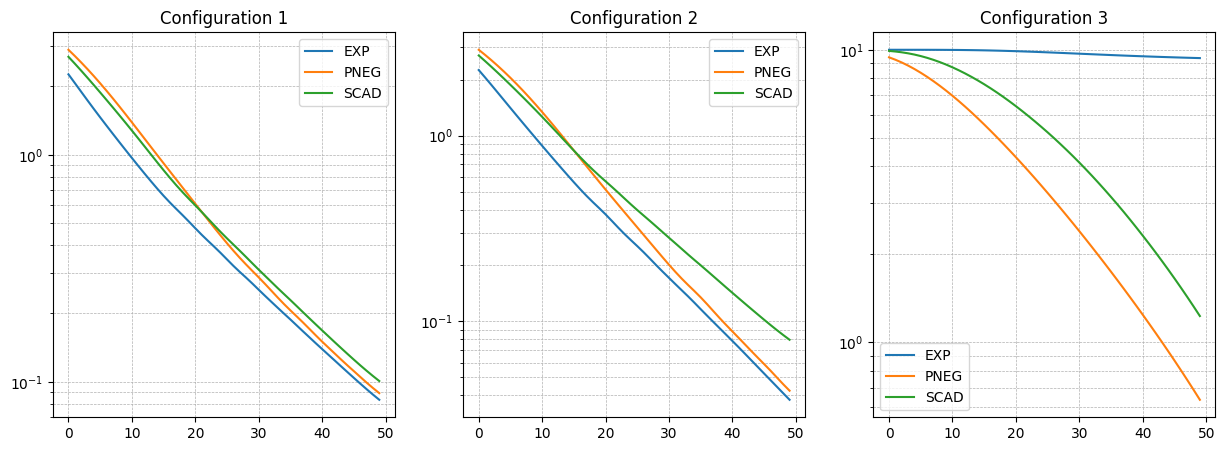

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for c in confs:

    for m in modes:
        axes[c-1].set_title(f"Configuration {c}")
        axes[c-1].plot(np.mean(test_loss_experiment_1[c][m][~np.isnan(test_loss_experiment_1[c][m]).any(axis=1)], axis = 0), label = f'{m}')
        axes[c-1].legend()
   
        axes[c-1].legend()
        axes[c-1].set_yscale('log')
        axes[c-1].grid(True, which="both", ls="--", linewidth=0.5)

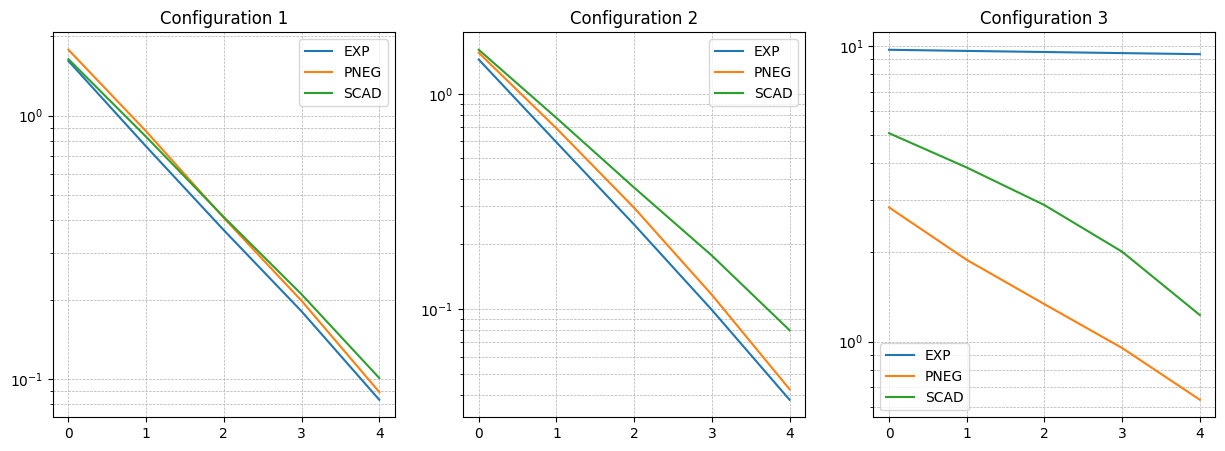

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for c in confs:

    for m in modes:

        axes[c-1].set_title(f"Configuration {c}")
        axes[c-1].plot(np.mean(inference_errs_experiment_1[c][m][~np.isnan(inference_errs_experiment_1[c][m]).any(axis=1)], axis = 0), label = f'{m}')
         
        axes[c-1].legend()
        axes[c-1].set_yscale('log')
        axes[c-1].grid(True, which="both", ls="--", linewidth=0.5)

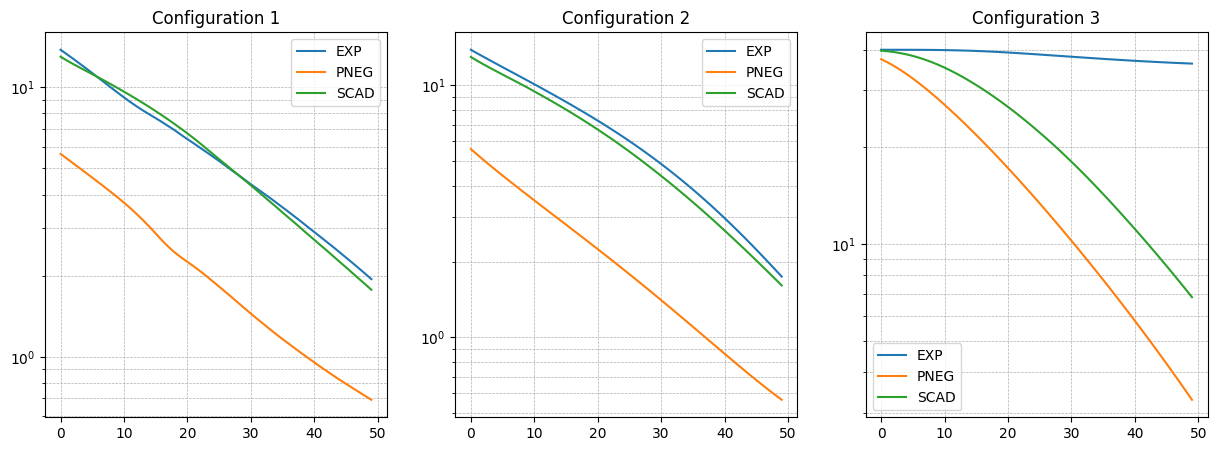

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for c in confs:

    for m in modes:
        axes[c-1].set_title(f"Configuration {c}")
        axes[c-1].plot(np.mean(test_loss_experiment_2[c][m][~np.isnan(test_loss_experiment_2[c][m]).any(axis=1)], axis = 0), label = f'{m}')
        axes[c-1].legend()
        axes[c-1].set_yscale('log')
        axes[c-1].grid(True, which="both", ls="--", linewidth=0.5)

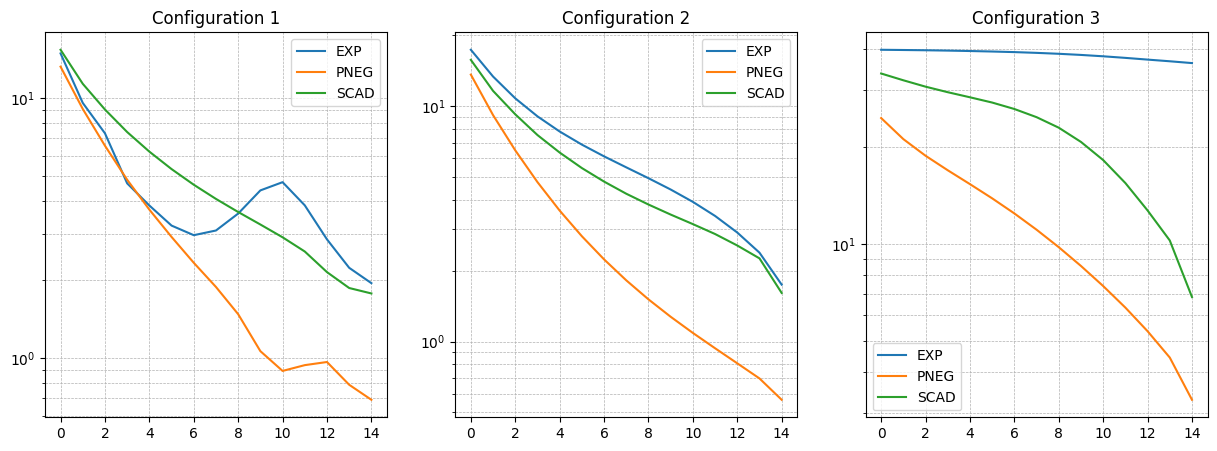

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for c in confs:

    for m in modes:

        axes[c-1].set_title(f"Configuration {c}")
        axes[c-1].plot(np.mean(inference_errs_experiment_2[c][m][~np.isnan(inference_errs_experiment_2[c][m]).any(axis=1)], axis = 0), label = f'{m}')
        axes[c-1].legend()
        axes[c-1].set_yscale('log')
        axes[c-1].grid(True, which="both", ls="--", linewidth=0.5)